# Modelo de Kermack McKendrick

hola

In [1]:
include("Taylor.jl")
using ADT

Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [2]:
function coefs_1(gamma, beta, S0, I0, R0 = 0.0, n = 20)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = -beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n-1
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = F1(Ts,Ti) # F1 = -b*S*I
        fr = F2(Ti) # F2 = g*I
        
        fi = -fs -fr # = b*S*I - g*I
        
        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 3 methods)

Prueba

In [3]:
N = 1000.;
I0 = 1.;
S0 = N-I0;

@time S,I,R = coefs_2(gamma, beta, S0, I0);

LoadError: LoadError: UndefVarError: coefs_2 not defined
while loading In[3], in expression starting on line 155

Error absoluto

In [4]:
eps_abs = 1e-20

1.0e-20

In [5]:
function paso(a::Taylor, p = 20)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [6]:
paso(S[1])

LoadError: LoadError: UndefVarError: S not defined
while loading In[6], in expression starting on line 1

In [7]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [8]:
function integrador_kermack(N, I0, t0, tf, gamma, beta)
    
    R0 = 0.
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 1 method)

In [9]:
N = 1.
infectados_iniciales = N/1000
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, t_inicial, t_final, gamma, beta);

  0.701833 seconds (2.07 M allocations: 56.008 MB, 2.59% gc time)


In [10]:
length(s)

74

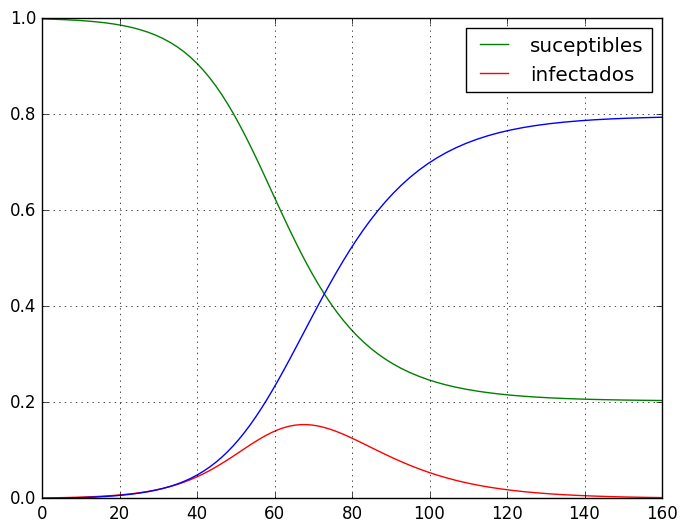

In [11]:
using PyPlot

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,1-s-i)
axis([0,160,0,1])
grid()
legend()
show()

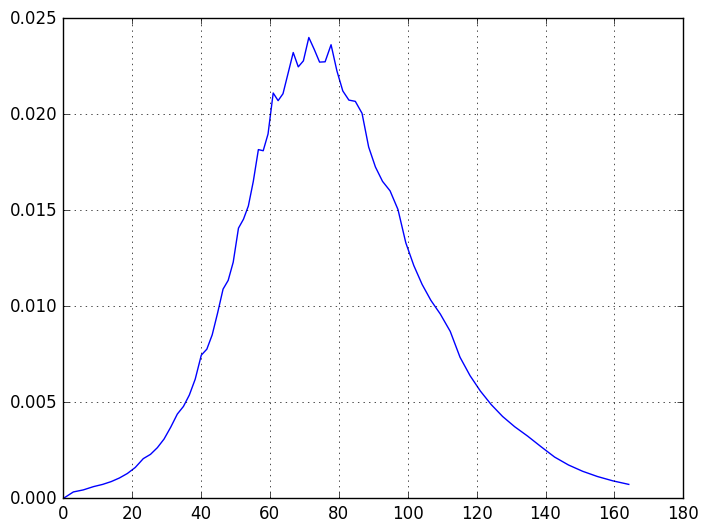

In [12]:
plot(t,r)
grid()

In [13]:
function wtf()
    return "WTF"
end

wtf (generic function with 1 method)

In [14]:
mi_reaccion_ante_la_grafica_de_r = wtf()

"WTF"

In [15]:
S,I,R = coefs_1(gamma, beta, S0, I0);
h = paso(R);

a = evaluar(R,h), ev_horner(R,h);

a[1] == a[2]

false

In [16]:
min(paso(R),paso(S))

0.0017305278592308162

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [17]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0 = 0.0, n = 20)
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])

        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            
            fi = -fs - F2(gamma[i],Ti[i])
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    
    return s,i
end

coefs_3 (generic function with 3 methods)

In [18]:
beta = rand(3,3)/3
gamma = rand(3)/8

3-element Array{Float64,1}:
 0.117404 
 0.0417822
 0.0496668

In [19]:
S0_1 = 99.
S0_2 = 90.
S0_3 = 93.
I0_1 = 1.
I0_2 = 3.
I0_3 = 2.

@time coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3);

  0.371507 seconds (638.88 k allocations: 27.115 MB, 1.47% gc time)


In [106]:
function kermack_3(N1, N2, N3, I0_1, I0_2, I0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1
    S0_2 = N2 - I0_2
    S0_3 = N3 - I0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[2][end]
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        S,I = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3)
        for k in 1:3
            h_s = paso(S[k])
            h_i = paso(I[k])
            h = min(h_s, h_i)
        
            t0 += h
        
            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
        
            push!(t,t0)
            push!(s[k],S0)
            push!(i[k],I0)
        end
        
    end
    return t,s,i
end

kermack_3 (generic function with 1 method)

In [69]:
S,I = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I1, I2, I3);

In [91]:
h_s = paso(S[1])
h_i = paso(I[1])
h = min(h_s, h_i)
s0 = ev_horner(S[1], h)

0.49254270847469256

In [159]:
t0 = 1.
while t0 < 1.5
    S,I = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3)
    for k in 1:3
        h_s = paso(S[k])
        h_i = paso(I[k])
        h = min(h_s, h_i)
        
        t0 += h
        S0 = ev_horner(S[k],h)
        I0 = ev_horner(I[k],h)
        
        push!(t,t0)
        push!(s[k],S0)
        push!(i[k],I0)
        end
        
    end

In [160]:
t

29-element Array{Float64,1}:
 0.0    
 1.10583
 1.10583
 1.20569
 1.34217
 1.448  
 1.54786
 1.68433
 1.79016
 1.89002
 2.0265 
 2.13233
 2.23219
 ⋮      
 2.81666
 2.91652
 3.05299
 1.10583
 1.20569
 1.34217
 1.10583
 1.20569
 1.34217
 1.448  
 1.54786
 1.68433

In [149]:
s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])

3-element Array{Array{Float64,1},1}:
 [1.0]
 [3.0]
 [2.0]

In [99]:
S,I = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3);

In [101]:
S[1].pol

20-element Array{Float64,1}:
  0.495      
 -0.684073   
  0.415823   
 -0.106625   
 -0.0276558  
  0.0355895  
 -0.0120381  
 -0.00134227 
  0.00314413 
 -0.00128155 
 -1.59688e-5 
  0.000275244
 -0.000134281
  9.53126e-6 
  2.34698e-5 
 -1.38199e-5 
  2.00447e-6 
  1.91512e-6 
 -1.39336e-6 
  2.9824e-7  

In [95]:
push!(i[1], i0)

2-element Array{Float64,1}:
 0.005     
 0.00629429

In [92]:
push!(s[1], s0)

2-element Array{Float64,1}:
 0.495   
 0.492543

In [122]:
N1 = 0.5
N2 = 0.3
N3 = 0.2
I1 = N1/100
I2 = N2/100
I3 = N3/100
t_3,s_3,i_3 = kermack_3(N1, N2, N3, I1, I2, I3, 0., 10., gamma, beta)

([0.0,1.614427320424363,3.312072407784895,5.075500757473631,6.598973574594021,8.08571479342093,9.926841323552889,11.340921723625575,12.736057494303923,14.403316138562829],[[0.495,0.4927451934718649,0.4900723135665016,0.4870086926686782],[0.297,0.295292859672395,0.29338865753074883,0.2911515515991626],[0.198,0.296413874933479,0.29454202026487364,0.29256762655872687]],[[0.005,0.006198091466261713,0.007638246621163709,0.009300302680725504],[0.003,0.0044451874210873505,0.006025896266514799,0.007860026743384365],[0.002,0.0023943297707023116,0.0029038445434843947,0.0034621245281693785]])

In [158]:
using PyPlot
t

23-element Array{Float64,1}:
 0.0    
 1.10583
 1.10583
 1.20569
 1.34217
 1.448  
 1.54786
 1.68433
 1.79016
 1.89002
 2.0265 
 2.13233
 2.23219
 2.36866
 2.47449
 2.57435
 2.71083
 2.81666
 2.91652
 3.05299
 1.10583
 1.20569
 1.34217